<h1>
    <center>
        <font size="6">Test result prediction</font>
    </center>
</h1>
<center><img src="Imgs/BloodTest.jpeg" width="800" height = "100"></img></center>

<!-- Notebook contents -->
<b><h3><a id=0> Content</a></h3></b>

- <b><a href='#0' style="text-decoration:none;">Problem Statement</a></b> 
- <b><a href='#1' style="text-decoration:none;">Functions</a></b>  
- <b><a href='#3' style="text-decoration:none;">Data Preprocessing </a></b>  
- <b><a href='#2' style="text-decoration:none;">Feature Engineering & Selection</a></b>    
- <b><a href='#4' style="text-decoration:none;">Modelling </a></b>   
- <b><a href='#5' style="text-decoration:none;">Models comparison & Room for improvement </a></b>   

<!-- Problem Statement Explanation -->
<center><h2 style="font-family: 'Times New Roman', Times, serif;">
        <font size="5.5">Importance of a Software for Detecting  Test Results</font>
</h2>
<br>
<b> 
An application that can determine if a test result is normal or abnormal has the potential to transform healthcare by allowing for immediate action, increasing patient outcomes, and streamlining healthcare process.               The application can eliminate human error, improve accessibility, and enable patients to take an active part in their health management by automating result analysis and classification.                                Furthermore, the app can help with public health monitoring, resource optimisation, cost reductions, and data-driven healthcare.</b>

<!-- Notebook Data -->
## Data:
 
| Attributes | Representation|
| -------- | ---------- |
| Name| This column represents the name of the patient|
| Age| The age of the patient at the time of admission| 
| Gender| Indicates the gender of the patient, Male or Female|
| Blood Type| The patient's blood type ex. AB+ A+ O-|
| Medical Condition | The medical condition of  the patient, ex. Diabetes Asthma|
| Date of Admission| The date on which the patient was admitted to the healthcare facility |
| Doctor| The name of the doctor responsible for the patient's care during their admission |
| Hospital| The healthcare facility or hospital where the patient was admitted |
| Insurance Provider | The patient's insurance provider ex. Aetna, Blue Cross, Cigna|
| Billing Amount | The amount of money billed for the patient's healthcare services|
| Room Number | The room number where the patient was accommodated|
| Admission Type | Type of admission, Emergency Urgent reflecting the circumstances of the admission.|
| Discharge Date | The date on which the patient was discharged from the healthcare facility|
| Medication | The medication prescribed to the patient ex  Aspirin, Ibuprofen|
| Test Results | The results of a medical test conducted during the patient's admission. Normal or  Abnormal|

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as stats
from sklearn.model_selection import train_test_split 

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib

In [2]:
df = pd.read_excel("Dataset/student_helthcare_dataset_train.xlsx")

In [3]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
1,Chad Byrd,61,Male,B-,NaN,2019-01-09,Paul Baker,Walton LLC,Medicare,0.000000,292,Emergency,2019-02-08,Lipitor,Normal
2,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,-480,Urgent,2020-05-03,Penicillin,Abnormal
3,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,-18086.344184,477,Urgent,2021-08-02,NaN,Normal
4,Patrick Parker,41,Male,AB+,Arthritis,2020-08-20,Robin Green,Boyd PLC,Aetna,22522.363385,180,Urgent,2020-08-23,Aspirin,Abnormal


# <center><a id="1">Functions</a></center>  

In [4]:
def ConvertAgerange(agesinyears):
    '''
    Converts ages in years to age ranges
    
    Args:
    - agesinyears (int): Age in years
    
    Returns:
    - str: Age range (child, adolescent, adult, elder)
    '''
    if agesinyears < 12:
        return 'Child'
    elif agesinyears < 20:  
        return 'Adolescent'
    elif agesinyears < 60:  
        return 'Adult'
    else:
        return 'Elder'

In [5]:
def categorize_billing_amount(amount):
    """
    Categorize billing amount into ranges (low, medium, high).

    Args:
        amount (float): Billing amount.

    Returns:
        str: Category (low, medium, high).
    """
    if amount < 5000:
        return 'Low'
    elif 5000 <= amount < 15000:
        return 'Medium'
    else:
        return 'High'


In [6]:
def handle_outlier(col, threshold=1.5):
    '''
    Function that gets maximum and minimum values for the provided column
    
    Args:
        col (pandas.Series): Column name
        threshold (float): Threshold value for defining outliers
    
    Returns:
        tuple: The lower and upper bounds for outliers
    '''
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = max(0, Q1 - (threshold * IQR))
    upper = Q3 + (threshold * IQR)
    return lower, upper

In [7]:
def draw_boxplot(colname):
    '''
    Creates a boxplot for the specified column
    
    Args:
        colname (str): Column name
        
    Returns:
        None
    '''
    sns.boxplot(df[colname])
    plt.xlabel(colname)
    plt.ylabel('Value')
    plt.title(f'Boxplot of {colname}')
    plt.show()

In [8]:
colors = ['#4dc1c4', '#63c9cb', '#79d0d3', '#90d8da', '#a6e0e1', '#bce7e9', '#d2eff0', '#e8f7f7']
def plot_mi_scores(scores, colors=colors):
    '''
    Plot Mutual Information Scores for Features in a Horizontal Bar Chart.

    Parameters:
    - scores (pd.Series): Series containing mutual information scores for each feature.
    - colors (list or str, optional): Color or list of colors for the bars. Default is None.

    Returns:
    None

    Example:
    ```python
    # Assuming 'mi_scores' is a Pandas Series with mutual information scores
    plot_mi_scores(mi_scores, colors='skyblue')
    plt.show()
    ```
    '''
    # Sort scores in ascending order for better visualization
    scores = scores.sort_values(ascending=True)

    # Create a horizontal bar chart
    scores.plot(kind='barh', color=colors)

    # Set labels and title
    plt.xlabel('Mutual Information Scores')
    plt.ylabel('Features')
    plt.title('Mutual Information Scores for Features')

# <center><a id="3">Data Preprocessing</a></center>  

### Rename columns to remove spaces

In [9]:
df.rename(columns={
    'Medical Condition': 'Medical_Condition',
    'Insurance Provider': 'Insurance_Provider',
    'Blood Type': 'Blood_Type',
    'Billing Amount': 'Billing_Amount',
    'Room Number': 'Room_Number',
    'Admission Type': 'Admission_Type',
    'Test Results': 'Test_Results'
}, inplace=True)
df.rename(columns={'Date of Admission': 'Date_of_Admission', 'Discharge Date': 'Discharge_Date'}, inplace=True)

## Convert to Ranges

### Data ranges simplify data, making it easier to understand and interpret                                                      Instead of dealing with a large number of distinct values, grouping them into ranges reduces complexity.


- **Reduced Sensitivity to Small Variations:** Ranges are less sensitive to small variations, which can be particularly useful when dealing with noisy or imprecise data, predicting a range allows for a level of tolerance.

- **Handling Uncertainty:** Information might not always be precise, and individuals may not provide their exact data. Predicting their ranges accommodates this uncertainty and provides a more flexible approach to handling varied input.

- **Practical Application:** Ranges are often more practically applicable in various contexts. For example, in targeted marketing, you might be interested in reaching a specific age group rather than individuals of exact ages.

- **Model Generalization:** Predicting ranges can contribute to better generalization of models. It helps the model focus on broader patterns and trends associated with different life stages rather than memorizing exact data, which may not generalize well.

- **Interpretability:** Predicting ranges can enhance the interpretability of models instead of providing specific data, which might be less meaningful to end-users, ranges offer a clearer and more actionable output.


In [10]:
df.insert(2,"AgeRange",np.nan, True)
df.insert(11,"BillingRange",np.nan, True)

In [11]:
df['AgeRange'] = df['Age'].apply(ConvertAgerange)

In [12]:
df['BillingRange'] = df['Billing_Amount'].apply(categorize_billing_amount)

In [13]:
df.head()

,Name,Age,AgeRange,Gender,Blood_Type,Medical_Condition,Date_of_Admission,Doctor,Hospital,Insurance_Provider,Billing_Amount,BillingRange,Room_Number,Admission_Type,Discharge_Date,Medication,Test_Results
0,Ruben Burns,35,Adult,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,High,404,Emergency,2023-06-15,Lipitor,Normal
1,Chad Byrd,61,Elder,Male,B-,NaN,2019-01-09,Paul Baker,Walton LLC,Medicare,0.000000,Low,292,Emergency,2019-02-08,Lipitor,Normal
2,Antonio Frederick,49,Adult,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,High,-480,Urgent,2020-05-03,Penicillin,Abnormal
3,Mrs. Brandy Flowers,51,Adult,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,-18086.344184,Low,477,Urgent,2021-08-02,NaN,Normal
4,Patrick Parker,41,Adult,Male,AB+,Arthritis,2020-08-20,Robin Green,Boyd PLC,Aetna,22522.363385,High,180,Urgent,2020-08-23,Aspirin,Abnormal


### Handle Outliers

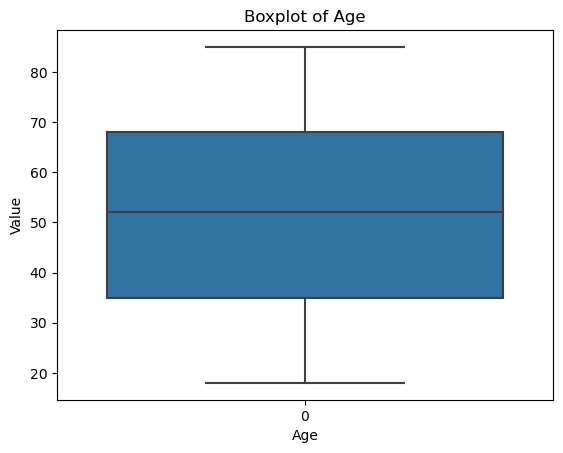

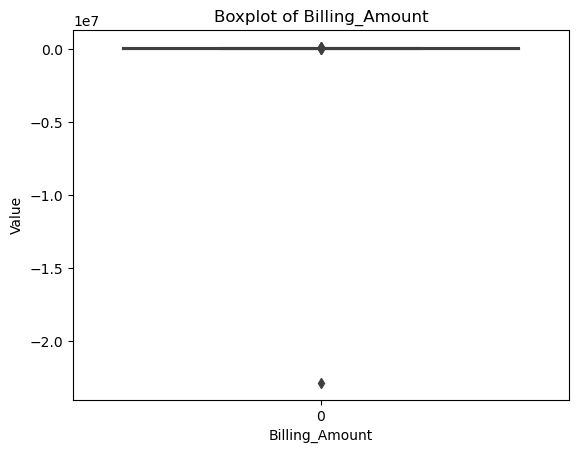

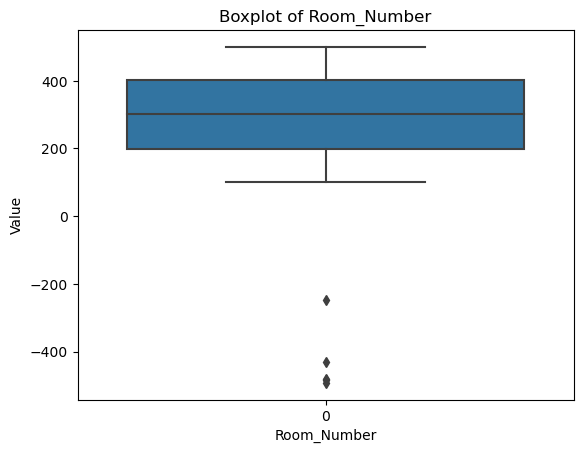

In [14]:
for col in df.columns:
    if df[col].dtype == 'object':
        pass
    else:
        draw_boxplot(col)

**There are no outliers to handle regarding age**                   
**Room numbers with -ve will be transformed to +ve**           
**The -ve values will be converted for billing, and the mean will be taken in the place of the 0s**

**Billing Amount**

In [15]:
df['Billing_Amount'] = df['Billing_Amount'].round().astype(int)

# Modify the column in-place
df['Billing_Amount'] = df['Billing_Amount'].apply(lambda x: -x if x < 0 else x)

minimum, maximum = handle_outlier(df['Billing_Amount'])

# Replace values above the upper bound with the maximum value and values below the lower bound with the minimum value
df['Billing_Amount'] = np.where(df['Billing_Amount'] < minimum, minimum, df['Billing_Amount'])
df['Billing_Amount'] = np.where(df['Billing_Amount'] > maximum, maximum, df['Billing_Amount'])

In [16]:
df['Billing_Amount'] = np.where(df['Billing_Amount'] == 0 , df['Billing_Amount'].mean(), df['Billing_Amount'])

In [17]:
df['Billing_Amount'].min()

1000.0

**Room Number**

In [18]:
# We can see that in Room Number column we have negative values
df['Room_Number'].unique()

array([ 404,  292, -480,  477,  180,  161,  384,  215,  310,  306, -492,
        238,  364,  130,  120,  293,  379,  298,  392,  456,  197,  247,
        228,  137,  192,  258,  219,  119,  412,  182,  359,  186,  132,
        361,  303,  439,  153,  380,  199,  301,  410,  205,  134,  188,
        213,  405,  358,  147,  115,  436,  263,  356,  142,  139,  482,
        141,  397,  347,  143,  108,  268,  176,  462,  329,  389,  275,
        181,  401,  214,  140,  179,  289,  350,  104,  220,  419,  445,
        398,  336,  413,  145,  148, -430,  406,  295,  175,  424,  261,
        451,  372,  202,  245,  394,  279,  260,  499,  452,  290,  187,
        334,  470,  162,  450,  106,  259,  344,  489,  276,  155,  425,
        400,  333,  443,  129,  486,  265,  459,  193,  222,  488,  472,
        391,  230,  322,  272,  154,  416,  236,  375,  244,  287,  243,
        465,  234,  458,  226,  478,  204,  294,  280,  374,  216,  135,
        225,  152,  444,  454,  442,  189,  487,  4

In [19]:
df['Room_Number'] = df['Room_Number'].apply(lambda x: -x if x < 0 else x)

### Nulls

In [20]:
df.isnull().sum()

Name                  0
Age                   0
AgeRange              0
Gender                0
Blood_Type            0
Medical_Condition     9
Date_of_Admission     0
Doctor                0
Hospital              0
Insurance_Provider    0
Billing_Amount        0
BillingRange          0
Room_Number           0
Admission_Type        0
Discharge_Date        0
Medication            8
Test_Results          0
dtype: int64

**Nulls appear in Medical Condition = 9 , Medication =  8**

In [21]:
# Assuming 'Medication' and 'Medical Condition' are columns in your DataFrame
grouped_data = df.groupby('Medical_Condition')['Medication'].unique().to_dict()

# Display the resulting dictionary
grouped_data

{'Arthritis': array([nan, 'Aspirin', 'Penicillin', 'Lipitor', 'Ibuprofen',
        'Paracetamol'], dtype=object),
 'Asthma': array(['Lipitor', 'Penicillin', 'Aspirin', 'Paracetamol', 'Ibuprofen',
        nan], dtype=object),
 'Cancer': array(['Penicillin', 'Lipitor', 'Aspirin', 'Paracetamol', 'Ibuprofen',
        nan], dtype=object),
 'Diabetes': array(['Aspirin', 'Penicillin', 'Paracetamol', 'Lipitor', 'Ibuprofen'],
       dtype=object),
 'Hypertension': array(['Lipitor', 'Paracetamol', 'Aspirin', 'Ibuprofen', 'Penicillin'],
       dtype=object),
 'Obesity': array(['Lipitor', 'Paracetamol', 'Ibuprofen', 'Aspirin', 'Penicillin',
        nan], dtype=object)}

In [22]:
# Fill null values with the most common medication for each medical condition
df['Medication'] = df['Medication'].fillna(df.groupby('Medical_Condition')['Medication'].transform(lambda x: x.mode().iloc[0]))

**There are just 9 rows with null values in medical conition and dropping these rows does not result in a significant loss of information as we can't impute the medical condition**

In [23]:
df.dropna(subset=['Medical_Condition'], inplace=True)

In [24]:
df.isnull().sum()

Name                  0
Age                   0
AgeRange              0
Gender                0
Blood_Type            0
Medical_Condition     0
Date_of_Admission     0
Doctor                0
Hospital              0
Insurance_Provider    0
Billing_Amount        0
BillingRange          0
Room_Number           0
Admission_Type        0
Discharge_Date        0
Medication            0
Test_Results          0
dtype: int64

### Duplicates

In [25]:
# 1 duplicated row
df.duplicated().sum()

1

In [26]:
#Dropped the duplicated row and saved in data
df.drop_duplicates(inplace = True)

### Correct Format for dates

In [27]:
df['Date_of_Admission'] = pd.to_datetime(df.Date_of_Admission)

In [28]:
df['Discharge_Date'] = pd.to_datetime(df.Discharge_Date)

In [29]:
df.dtypes

Name                          object
Age                            int64
AgeRange                      object
Gender                        object
Blood_Type                    object
Medical_Condition             object
Date_of_Admission     datetime64[ns]
Doctor                        object
Hospital                      object
Insurance_Provider            object
Billing_Amount               float64
BillingRange                  object
Room_Number                    int64
Admission_Type                object
Discharge_Date        datetime64[ns]
Medication                    object
Test_Results                  object
dtype: object

### Convert categorical to numerical

In [30]:
for column in df.columns:
    if df[column].dtype == 'object' or df[column].dtype ==  'datetime64[ns]':
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])

# <center><a id="2">Feature Engineering & Selection</a></center>  

In [31]:
df['Test_Results'].value_counts()

Test_Results
0    3093
1    2947
Name: count, dtype: int64

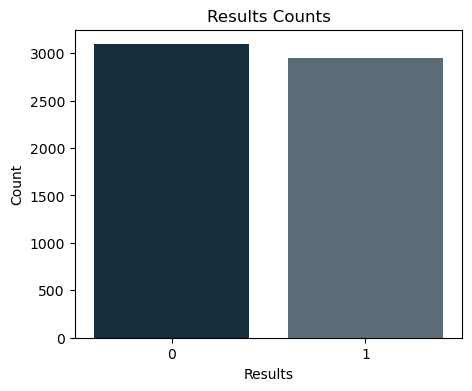

In [32]:
'''The data is balanced between the Normal & Abnormal'''

plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="Test_Results", palette=sns.color_palette(['#0E2F44', '#566D7C']))
plt.title("Results Counts")
plt.xlabel("Results")
plt.ylabel("Count")
plt.show()

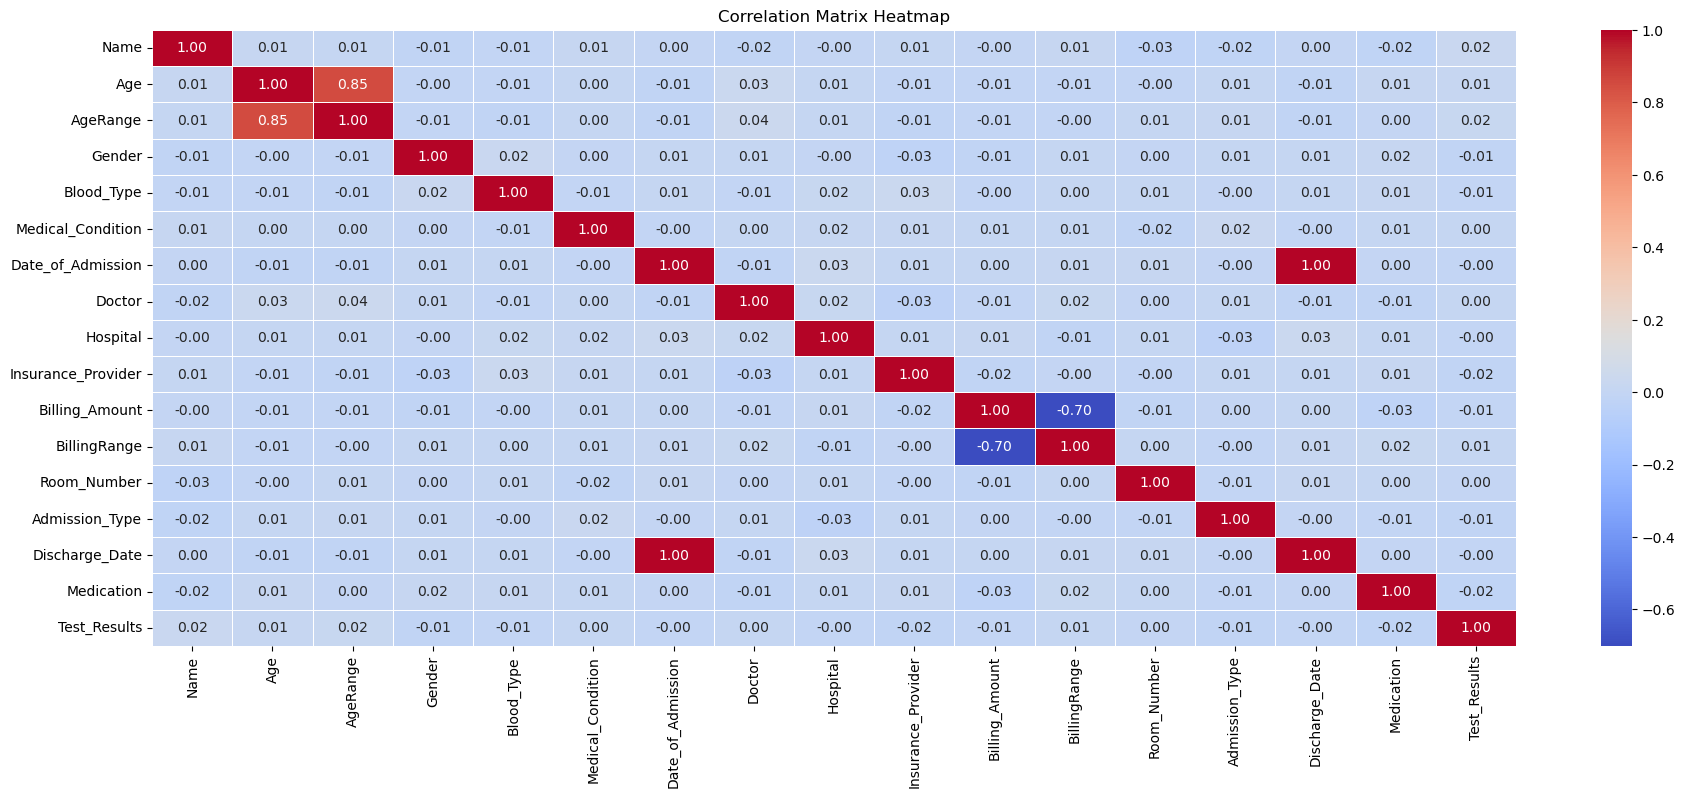

In [33]:
# Select numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr(method='pearson', min_periods=1)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(22, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Select using Mutual Information Score

In [34]:
# Select numeric columns excluding the target variable 'Test_Results'
DFnumeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
DFnumeric_columns = DFnumeric_columns.drop('Test_Results')

# Calculate Mutual Information scores between numeric features and the target variable
mi_scores = mutual_info_classif(df[DFnumeric_columns], df['Test_Results'], random_state=42)

# Create a Pandas Series with MI scores, using column names as index
mi_scores = pd.Series(mi_scores, name="MI Scores", index=DFnumeric_columns)


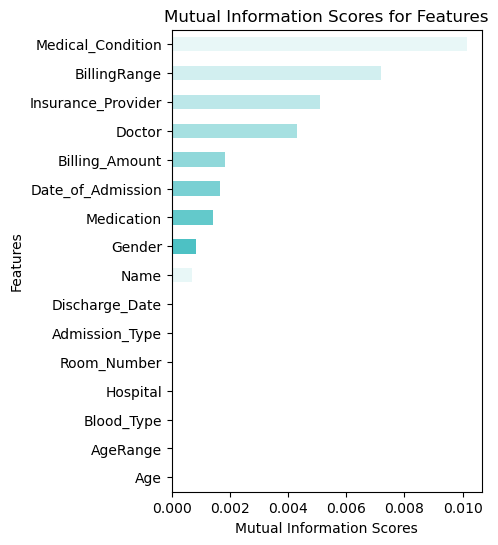

In [35]:
plt.figure(figsize=(4, 6))
plot_mi_scores(mi_scores)
plt.show()

# <center><a id="4">Modelling</a></center>  

### For models evaluation we'll use the following metrics:
- **Accuracy:** describing the number of correct predictions over all predictions both -ve & +ve
- **Precision:** represents how many of the positive predictions made are correct
- **Recall:** represents how many of the positive cases the classifier correctly predicted, over all the positive cases in the data
- **F1-Score:** indicates the strong overall performance of a binary classification model as it combines both the recall & precision

In [36]:
selected_features = ['Medical_Condition','Medication','Gender','Doctor','Billing_Amount','Admission_Type','AgeRange','Hospital']
X = df[selected_features]
y = df['Test_Results']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Scale to bring all features to a similar scale
**Ensures all features contribute equally, preventing dominance based on scale differences**     
**Helps gradient-based optimization algorithms converge faster**      
**Large differences in scale can lead to numerical instability or precision issue scaling helps mitigate these problems**  

**SVM & logistic regression often benefit from feature scaling.**

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### <center><a>SVM</a></center> 
**Support Vectors Classifier tries to find the best hyperplane to separate the different classes by maximizing the distance between sample points and the hyperplane.**

- Gamma is a parameter for non linear hyperplanes the higher the gamma value it tries to exactly fit the training data set increasing gamma leads to overfitting as the classifier tries to perfectly fit the training data
- C is the penalty parameter of the error term it controls the trade off between smooth decision boundary and classifying the training points correctly but also increasing C values may lead to overfitting

In [39]:
# Sigmoid limits the output between 0 - 1
svm_model = SVC(kernel = 'sigmoid',gamma = 2,C=0.1)
svm_model.fit(X_train_scaled,y_train)

SVC(C=0.1, gamma=2, kernel='sigmoid')

In [40]:
svm_ypred = svm_model.predict(X_test_scaled)

In [41]:
yTrain_svm = svm_model.predict(X_train_scaled)

**Check if model is overfitting**

In [42]:
print("Training Data: \n" +classification_report(y_train, yTrain_svm))

Training Data: 
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      2057
           1       0.46      0.46      0.46      1989

    accuracy                           0.47      4046
   macro avg       0.47      0.47      0.47      4046
weighted avg       0.47      0.47      0.47      4046



In [43]:
print("Testing Data: \n" + classification_report(y_test, svm_ypred))

Testing Data: 
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1036
           1       0.48      0.48      0.48       958

    accuracy                           0.50      1994
   macro avg       0.49      0.49      0.49      1994
weighted avg       0.50      0.50      0.50      1994



**The accuracies are not that different from when we were training which means that the model is not overfitting**

In [44]:
SVC_accuracy = accuracy_score(y_test, svm_ypred)
SVC_fscore = f1_score(y_test, svm_ypred)

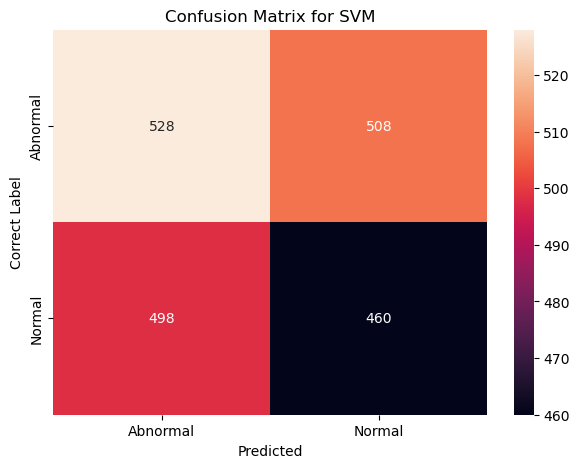

In [45]:
svm_cm = confusion_matrix(y_test, svm_ypred)

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for SVM')
sns.heatmap(svm_cm, annot=True, xticklabels=['Abnormal','Normal'],
           yticklabels=['Abnormal','Normal'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')
plt.show()

### <center><a>Decision Tree (ID3)</a></center> 

In [46]:
DT_model = tree.DecisionTreeClassifier()

# hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['entropy']    
}

# grid search with cross-validation
''''''
grid_search = GridSearchCV(DT_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1], 'min_samples_split': [2]},
             scoring='accuracy')

In [47]:
# since best_params_, we have to refit the model & these should be unpacked when passed to the model
DT_model = tree.DecisionTreeClassifier(**grid_search.best_params_)

# Model training 
DT_model.fit(X_train_scaled,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [48]:
DT_ypred = DT_model.predict(X_test_scaled)

In [49]:
yTrain_DT = DT_model.predict(X_train_scaled)

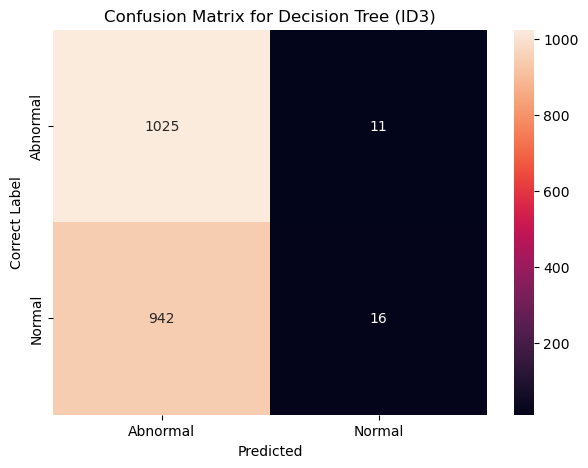

In [50]:
DT_cm = confusion_matrix(y_test, DT_ypred)

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for Decision Tree (ID3)')
sns.heatmap(DT_cm, annot=True, xticklabels=['Abnormal','Normal'],
           yticklabels=['Abnormal','Normal'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')
plt.show()

In [51]:
print("Testing data: \n"+ classification_report(y_test, DT_ypred))

Testing data: 
              precision    recall  f1-score   support

           0       0.52      0.99      0.68      1036
           1       0.59      0.02      0.03       958

    accuracy                           0.52      1994
   macro avg       0.56      0.50      0.36      1994
weighted avg       0.56      0.52      0.37      1994



In [52]:
print("Training data: \n"+ classification_report(y_train, yTrain_DT))

Training data: 
              precision    recall  f1-score   support

           0       0.51      0.99      0.68      2057
           1       0.71      0.02      0.04      1989

    accuracy                           0.51      4046
   macro avg       0.61      0.51      0.36      4046
weighted avg       0.61      0.51      0.36      4046



In [53]:
DT_accuracy = accuracy_score(y_test, DT_ypred)
DT_fscore = f1_score(y_test, DT_ypred)

**The accuracies are not that different from when we were training which means that the model is not overfitting**

### <center><a>Logistic Regression</a></center> 

In [54]:
LR_model = LogisticRegression(solver = 'liblinear',C = 10,random_state = 42)

In [55]:
LR_model.fit(X_train_scaled,y_train)

LogisticRegression(C=10, random_state=42, solver='liblinear')

In [56]:
LR_ypred = LR_model.predict(X_test_scaled)

In [57]:
yTrain_LR = LR_model.predict(X_train_scaled)

In [58]:
print("Training data: \n"+ classification_report(y_train, yTrain_LR))

Training data: 
              precision    recall  f1-score   support

           0       0.53      0.65      0.58      2057
           1       0.52      0.40      0.46      1989

    accuracy                           0.53      4046
   macro avg       0.53      0.52      0.52      4046
weighted avg       0.53      0.53      0.52      4046



In [59]:
print("Testing Data: \n" + classification_report(y_test, LR_ypred))

Testing Data: 
              precision    recall  f1-score   support

           0       0.51      0.61      0.56      1036
           1       0.47      0.37      0.42       958

    accuracy                           0.50      1994
   macro avg       0.49      0.49      0.49      1994
weighted avg       0.49      0.50      0.49      1994



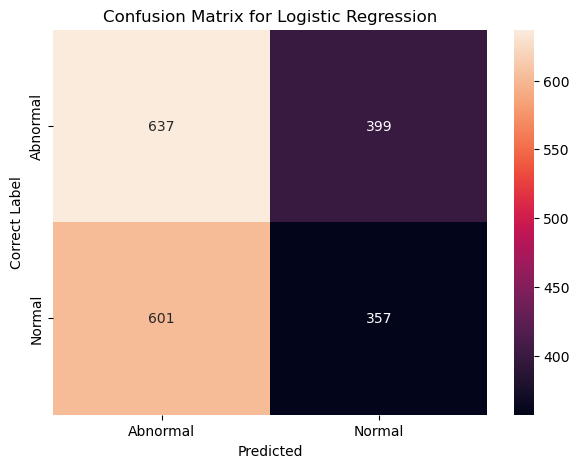

In [60]:
LR_cm = confusion_matrix(y_test, LR_ypred)

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for Logistic Regression')
sns.heatmap(LR_cm, annot=True, xticklabels=['Abnormal','Normal'],
           yticklabels=['Abnormal','Normal'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')
plt.show()

In [61]:
LR_accuracy = accuracy_score(y_test, LR_ypred)
LR_fscore = f1_score(y_test, LR_ypred)

# <center><a id="2">Models comparison</a></center>  

In [62]:
Models_Scores = pd.DataFrame({'Models':['SVC','Decision Tree','Logistic Regression'],
             'Accuracy':[SVC_accuracy,DT_accuracy,LR_accuracy],
             'Fscore': [SVC_fscore,DT_fscore,LR_fscore]})
Models_Scores.head()

,Models,Accuracy,Fscore
0,SVC,0.495486,0.477674
1,Decision Tree,0.522066,0.032487
2,Logistic Regression,0.498495,0.416569


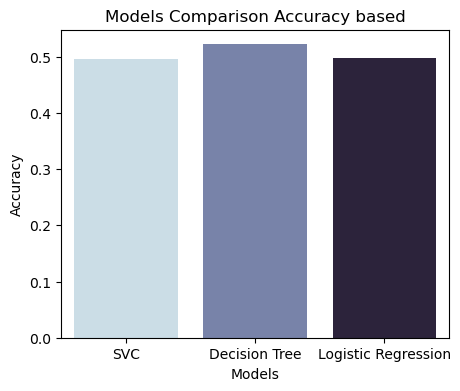

In [63]:
plt.figure(figsize=(5,4))
plt.title('Models Comparison Accuracy based')
figure = sns.barplot(x = Models_Scores['Models'],y = Models_Scores['Accuracy'],palette='ch:s=.25,rot=-.25', width=0.8)


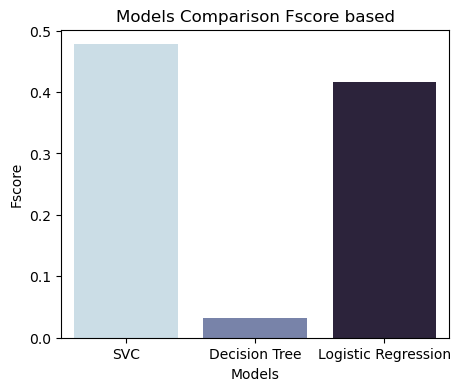

In [64]:
plt.figure(figsize=(5,4))
plt.title('Models Comparison Fscore based')
figure = sns.barplot(x = Models_Scores['Models'],y = Models_Scores['Fscore'],palette='ch:s=.25,rot=-.25', width=0.8)

**Both models preformed similarly in terms of accuracy but as for the f1 score we can deduct that the SVC & logistic regression preformed way better which indicates that these models have a good balance between making accurate positive predictions (precision) and capturing all actual positive instances (recall)**

**Models saving**

In [65]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [66]:
joblib.dump(label_encoder, 'encoder.pkl')

['encoder.pkl']

In [67]:
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

In [68]:
joblib.dump(DT_model, 'DT_model.pkl')

['DT_model.pkl']

In [69]:
joblib.dump(LR_model, 'LR_model.pkl')

['LR_model.pkl']